In [1]:
import os
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import csv

In [2]:
## trasnport metrics time series

def transport_events(raw_files, h, window_size=40, duration_threshold=20, threshold_multiple=3):
    def find_corresponding_file_name(vvel_number_to_find):
        with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
            vvel_list = file.readlines()
        vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
        vvel_filename = None
        for filename in vvel_list:
            if vvel_dict[filename.split()[1]] == vvel_number_to_find:
                vvel_filename = filename.split()[1]  
                break
        return vvel_filename
    
    # Load data
    signals = np.load(raw_files[h])
    hist_end = (2014 - 1850) * 12
    signals = signals[:hist_end]
    time_annual = np.arange(1850, 1850 + (hist_end / 12))

    # Define criteria_indices_dict
    criteria_indices_dict = {}

    # Iterate over each time series
    for i, signal in enumerate(signals.T):
        # Calculate annual means
        annual_means = np.mean(signal.reshape(-1, 12), axis=1)

        # Find criteria indices
        criteria_indices = []
        for j in range(window_size, len(annual_means) - duration_threshold):
            window = annual_means[j - window_size:j]
            std_window = np.std(window)
            avg_window = np.mean(window)

            threshold = annual_means[j:j + duration_threshold]
            avg_threshold = np.mean(threshold)

            if avg_threshold >= avg_window + (threshold_multiple * std_window) or \
                    avg_threshold <= avg_window - (threshold_multiple * std_window):
                if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                    criteria_indices.append(j)

        criteria_indices_dict[i] = criteria_indices

    # Filter out non-empty criteria indices
    result = [(index, value) for index, value in criteria_indices_dict.items() if value]

    # Write results to CSV
    with open('events_dens_spg.csv', 'w', newline='') as csvfile:
        fieldnames = ['Index', 'Values']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for index, values in result:
            writer.writerow({'Index': index, 'Values': values[0]})
                
    # Save event and member_name
    saved_data = []
    for index, values in result:
        file_name = find_corresponding_file_name(index)[5:-3]
        annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
        
        start = values[0]
        end = values[0] + duration_threshold
        event = annual_means[start - window_size:end]
        
        
        saved_data.append((file_name, event))
        
    return saved_data

## NAO timeseries

def compute_NAO(file_path):
    psl_ds = xr.open_dataset(file_path)
    reduced_ds = psl_ds.roll(lon=-80).isel(lat=slice(120, 170), lon=slice(135, 240))
    data = reduced_ds.PSL.values
    weights = reduced_ds.gw.isel(time=0).values
    weights = weights[np.newaxis, :, np.newaxis]
    reduced_ds.close()

    weighted_data = data * weights
    shape = weighted_data.shape
    data_2d = weighted_data.reshape(shape[0], -1)

    mean_per_time_step = np.nanmean(data_2d, axis=1)
    nan_indices = np.isnan(data_2d)
    data_2d[nan_indices] = np.take(mean_per_time_step, np.where(nan_indices)[0])

    mean = np.mean(data_2d, axis=0)
    centered_data = data_2d - mean

    cov_matrix = np.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    first_principal_component = np.dot(centered_data, eigenvectors[:, 0])
    first_principal_component = first_principal_component[:-1]

    eof1_map = eigenvectors[:, 0].reshape(shape[1:])
    rows, cols = eof1_map.shape
    upper_right_quadrant = eof1_map[:rows // 2, cols // 2:]
    if np.mean(upper_right_quadrant) < 0:
        first_principal_component = -first_principal_component

    return first_principal_component

def compute_moving_average(data, mean_NAO, std_NAO, window_size):
    standardized_pc = (data - mean_NAO) / std_NAO
    moving_avg = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    if len(standardized_pc) < 70:
        gap = 70 - len(standardized_pc)
        moving_avg = np.concatenate((np.zeros(gap+9), moving_avg))
        standardized_pc = np.concatenate((np.zeros(gap), standardized_pc))
    else:
        moving_avg = np.concatenate((np.zeros(9), moving_avg))
    
    return moving_avg

def process_files(psl_files):
    all_first_pcs = []
    for file_path in psl_files:
        first_pc = compute_NAO(file_path)
        all_first_pcs.append(first_pc)
        
    combined_first_pcs = np.concatenate(all_first_pcs)
    mean_NAO = np.mean(combined_first_pcs)
    std_NAO = np.std(combined_first_pcs)
    
    results = []
    for idx, file_path in enumerate(psl_files):  
        first_pc = all_first_pcs[idx]
        standardized_pc = (first_pc - mean_NAO) / std_NAO
        
        moving_avg = compute_moving_average(standardized_pc, mean_NAO, std_NAO, 10)
        
        file_name = file_path[-11:-3]
        results.append((file_name, moving_avg[10:]))
    return results


## SPG density overturning

In [3]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
saved_data = transport_events(raw_files, h=7)
sorted_data = sorted(saved_data, key=lambda x: x[0])

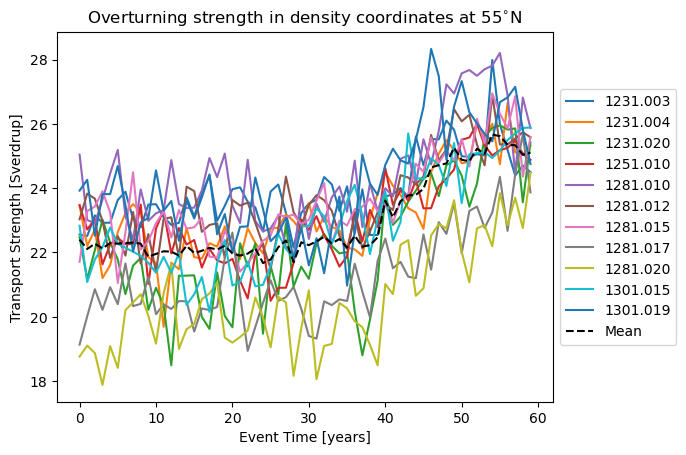

In [13]:
# make composite

time_series_list = []

# Plot the time series and collect data for averaging
fig = plt.figure()
for file_name, timeseries in sorted_data[1:]:
    if file_name != "1301.001":
        plt.plot(timeseries, label=file_name)
        time_series_list.append(timeseries)

# Compute the mean time series
mean_time_series = np.mean(time_series_list, axis=0)

# Plot the mean time series
plt.plot(mean_time_series, label='Mean', linestyle='--', color='black')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Overturning strength in density coordinates at 55$^{\circ}$N')
plt.xlabel('Event Time [years]')
plt.ylabel('Transport Strength [Sverdrup]')
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'sdens_55deg.png', bbox_inches='tight', dpi=300)

In [6]:
np.save(os.path.expanduser('~/phase1_CONDA/timeseries/spg_dens_mean.npy'), mean_time_series)

## NAO computation

In [7]:
psl_files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/psl_composite_*.nc'))
NAO_data = process_files(psl_files)

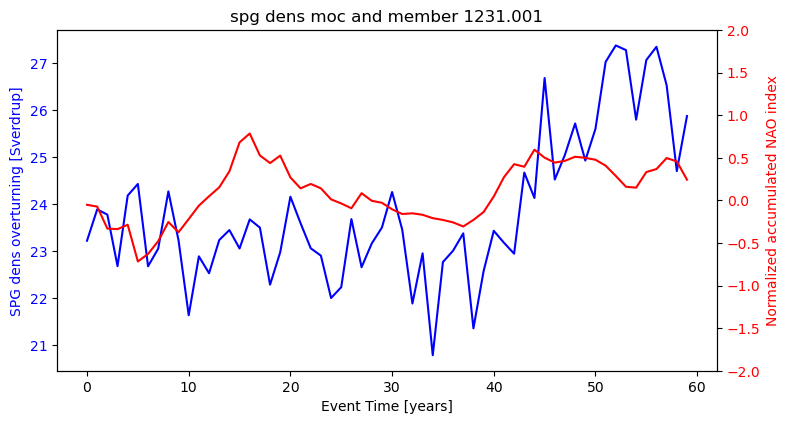

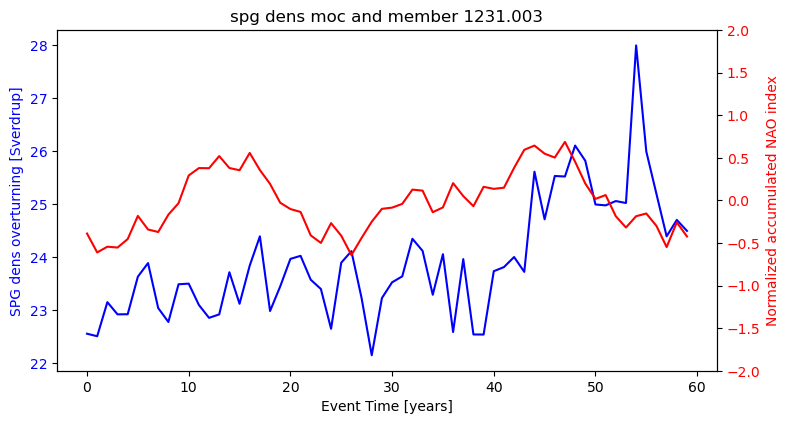

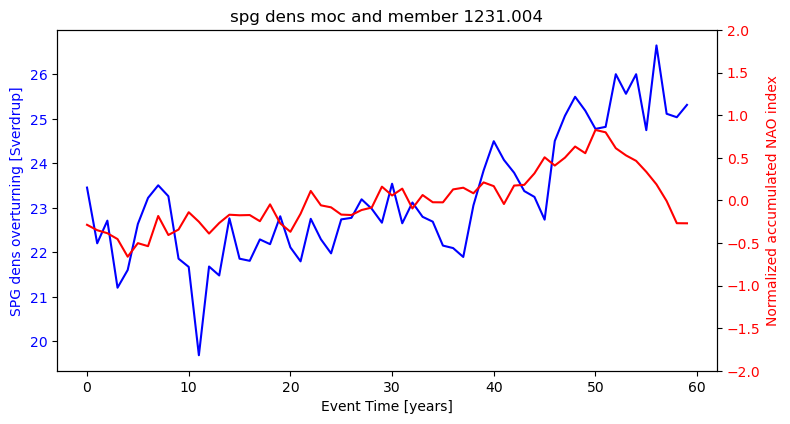

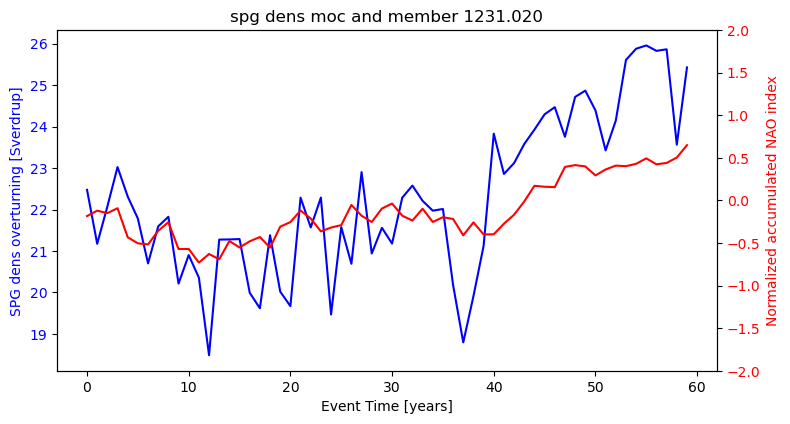

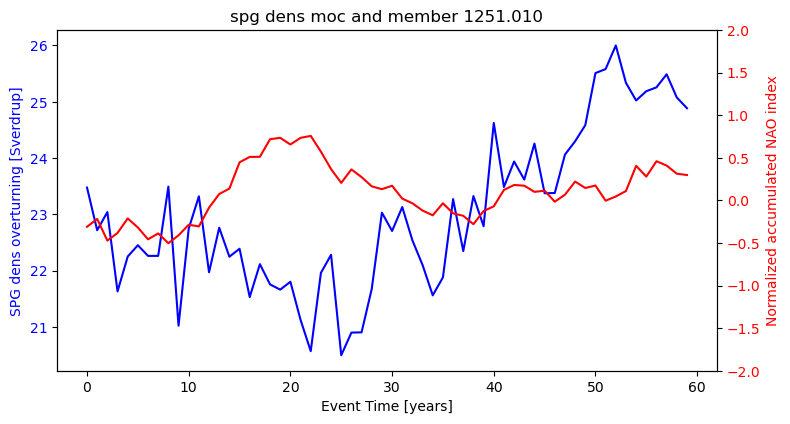

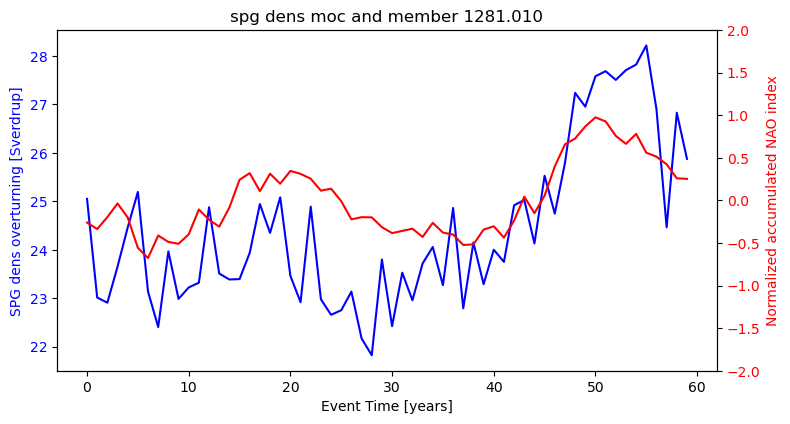

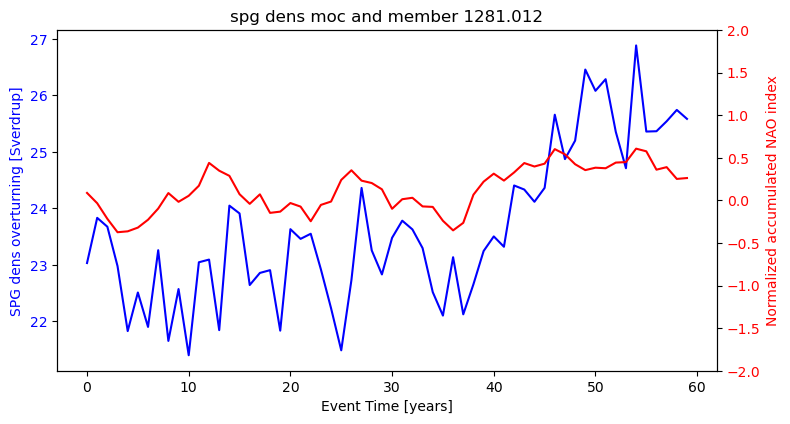

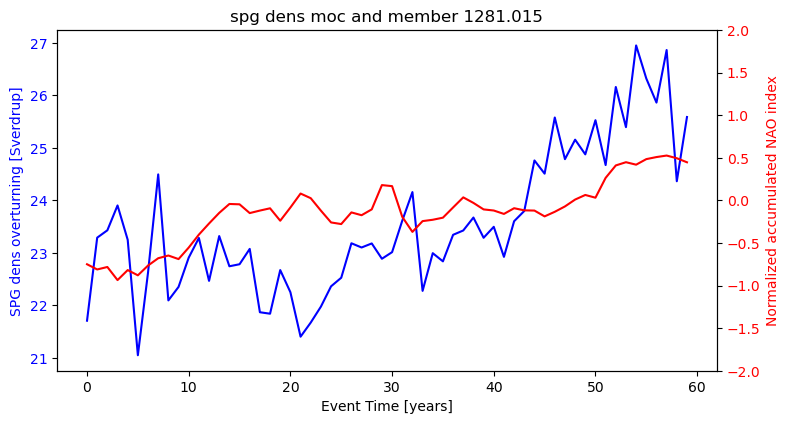

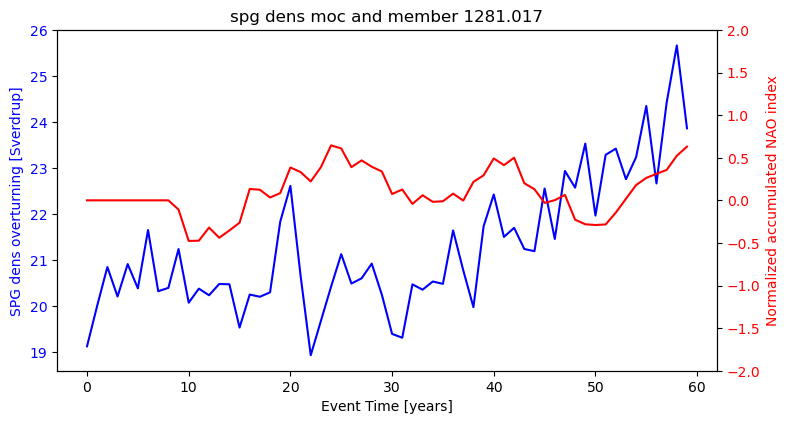

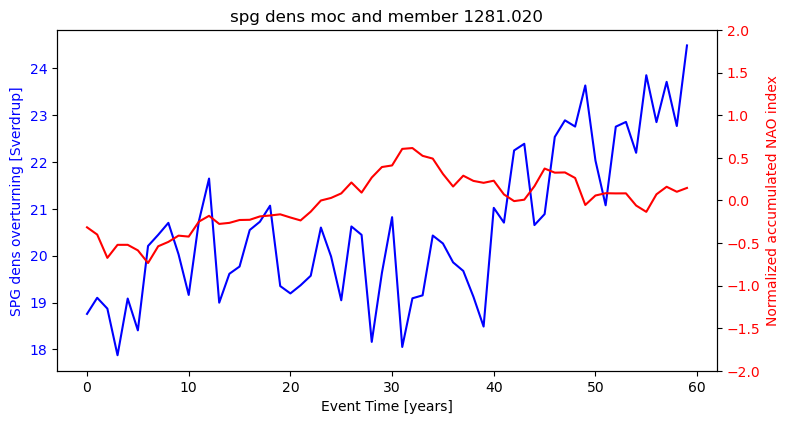

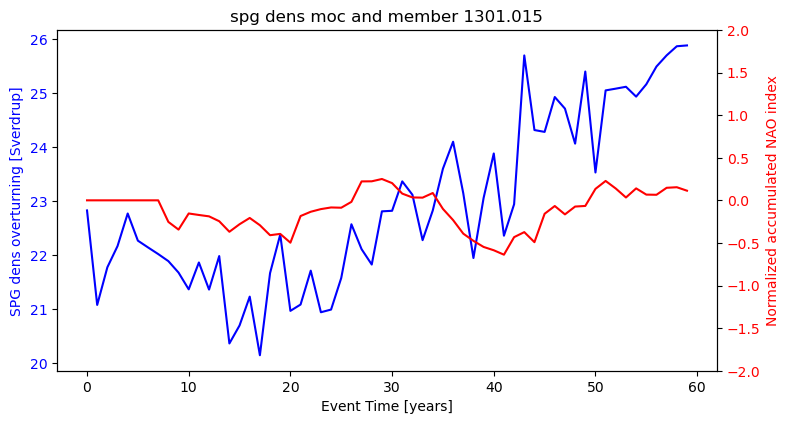

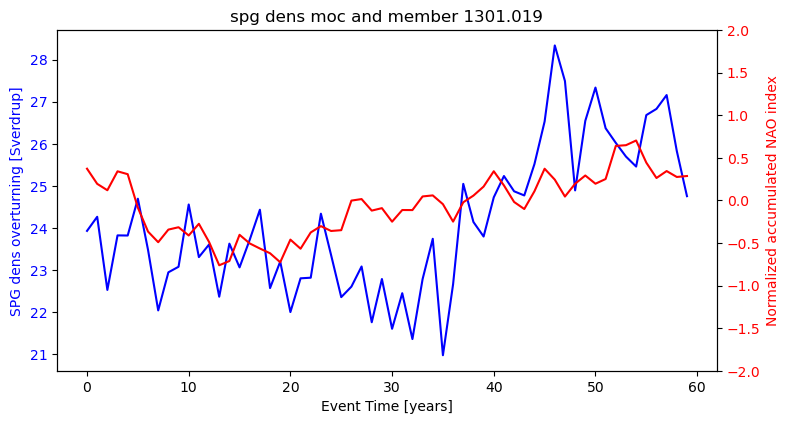

In [9]:
for file_name, sorted_timeseries in sorted_data:
    if file_name != "1301.001":
        fig, ax1 = plt.subplots(figsize=(8, 4))
        ax1.plot(sorted_timeseries, label='SPG dens overturning', color='blue')
        ax1.set_ylabel('SPG dens overturning [Sverdrup]', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()  
        for _, final_timeseries in NAO_data:
            if _ == file_name:
                ax2.plot(final_timeseries, label='Norm acc NAO', color='red')
                #break
        ax2.set_ylabel('Normalized accumulated NAO index', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_ylim(-2, 2)

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        #fig.legend(loc='upper left')
        ax1.set_title('spg dens moc and member ' + file_name)
        ax1.set_xlabel('Event Time [years]')
        plt.show()
        #plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+file_name+'_NAO_sdens.png', bbox_inches='tight', dpi=300)   

In [11]:
all_time_series_list = []

# Collect data for averaging
for file_name, sorted_timeseries in NAO_data:
    if file_name != "1301.001":
        all_time_series_list.append(sorted_timeseries)

# Compute the mean of all sorted time series apart from the excluded one
mean_all_time_series = np.mean(all_time_series_list, axis=0)

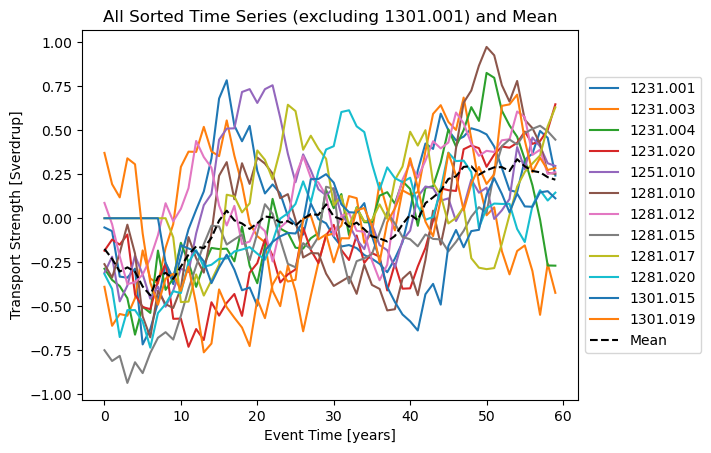

In [12]:
fig = plt.figure()

# Plot all sorted time series and collect data for averaging
for file_name, sorted_timeseries in NAO_data:
    if file_name != "1301.001":
        # Plot the current sorted time series
        plt.plot(sorted_timeseries, label=file_name)

# Plot the mean time series
plt.plot(mean_all_time_series, label='Mean', linestyle='--', color='black')

# Add labels, legend, and title
plt.xlabel('Event Time [years]')
plt.ylabel('Transport Strength [Sverdrup]')
plt.title('All Sorted Time Series (excluding 1301.001) and Mean')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'NAO_compilation.png', bbox_inches='tight', dpi=300)

In [19]:
np.save(os.path.expanduser('~/phase1_CONDA/timeseries/nao_mean.npy'), mean_all_time_series)